In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp
import reproject

In [3]:
from __future__ import unicode_literals

figsize(8,6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [4]:
lonc = 107.2
latc = 5.2
lonra = [105.6, 108.8]
latra = [3.6, 6.8]
d2r = np.pi / 180.

In [5]:
def plot_destriped(bank='A'):
    imfile = fits.open('destripingdata_bank'+bank+'_session5_weights.fits')
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    pixbeam = 1. 
    beamarea = np.pi / (4. * np.log(2)) * (beam / 60. * d2r)**2
    units = 1. / beamarea
    mdata = imfile[0].data
    newbeam = np.sqrt(beam**2 - pixbeam**2)
    sigma = newbeam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    dessignal = gaussian_filter(mdata, sigma) * units 
    
    hitmask = imfile[0].data != 0
    hits = np.zeros_like(imfile[0].data)
    hits[hitmask] = 1.
    shits = gaussian_filter(hits, sigma)
    
    mask = shits < 0.5
    dessignal[mask] = np.nan
    imfile[0].data = dessignal
    hpimage, footprint = reproject.reproject_to_healpix(imfile, 'galactic', nside=4096)
    return hpimage

In [6]:
bankA = plot_destriped('A')

In [7]:
bankB = plot_destriped('B')

In [8]:
bankC = plot_destriped('C')

In [9]:
nside = hp.get_nside(bankA)
vecc = hp.rotator.dir2vec(lonc, latc, lonlat=True)
rmask = hp.query_disc(nside, vecc, (45./60.)*d2r)
amaskout = set(hp.query_disc(nside, vecc, (80./60.)*d2r))
amaskin = set(hp.query_disc(nside, vecc, (60./60.)*d2r))
amask = np.array(list(amaskout.difference(amaskin)))

In [10]:
xdata = bankA * 1e-6
xdata -= np.nanmedian(xdata[amask])

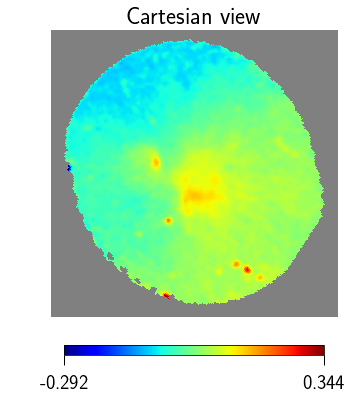

In [12]:
x = hp.cartview(xdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)

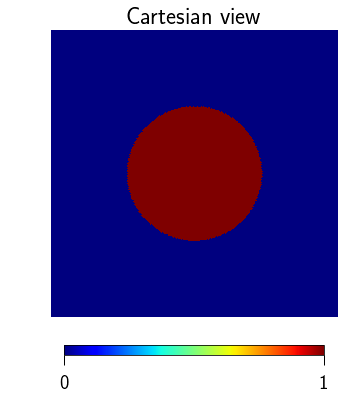

In [13]:
maskdata = np.zeros_like(xdata)
maskdata[rmask] = 1.
y = hp.cartview(maskdata, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)

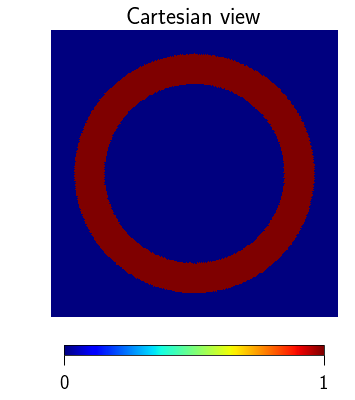

In [14]:
maskdata2 = np.zeros_like(xdata)
maskdata2[amask] = 1.
y2 = hp.cartview(maskdata2, lonra=lonra, latra=latra, return_projected_map=True, flip='geo')
fig = gcf()
ax = fig.axes[0]
img = ax.images[0]
X = np.linspace(img.get_extent()[0], img.get_extent()[1], 800)
Y = np.linspace(img.get_extent()[2], img.get_extent()[3], 800)

In [15]:
xmap = x.data
ymap = y.data.astype(bool)
ymap2 = y2.data.astype(bool)

In [16]:
RX, RY = np.meshgrid(X, Y)
XX = RX.flatten()
YY = RY.flatten()
Z = xmap.flatten()
masks = ~np.isnan(Z) * ~ymap.flatten()
data = np.c_[XX[masks], YY[masks], Z[masks]]
data2 = np.c_[XX, YY, Z]
A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
C, _, _, _ = linalg.lstsq(A, data[:, 2])
res = C[0] * RX + C[1] * RY + C[2]
xmap -= res

In [17]:
xmap -= np.nanmedian(xmap[ymap2])

In [221]:
print np.nansum(xmap[ymap] * 1e6 * (0.004 *d2r)**2)

26.6662336499


In [229]:
print np.nansum(xmap[ymap] * 1e6 * (0.004 *d2r)**2)

26.4697215168


In [240]:
print np.nansum(xmap[ymap] * 1e6 * (0.004 *d2r)**2)

28.9008905811


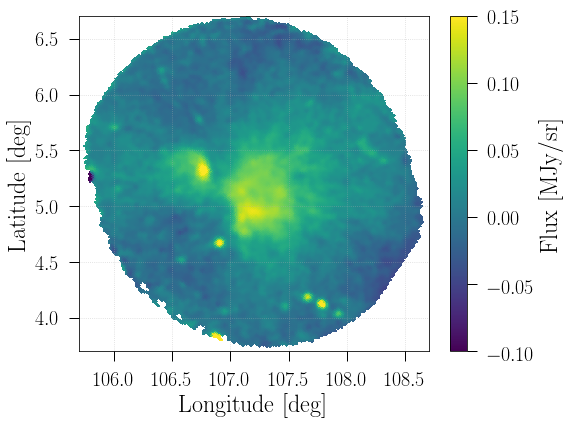

In [141]:
pc = pcolormesh(X, Y, xmap, rasterized=True)
clim(-0.1, 0.15)
cm = colorbar();
cm.set_label('$\mathrm{Flux\ [MJy / sr]}$')

#circ1 = Circle((rc, dc), (45./60), facecolor='None', lw=1, edgecolor='r')
#circ2 = Circle((rc, dc), (60./60), facecolor='None', lw=1, edgecolor='k')
#circ3 = Circle((rc, dc), (80./60), facecolor='None', lw=1, edgecolor='k')
#pc.axes.add_patch(circ1)
#pc.axes.add_patch(circ2)
#pc.axes.add_patch(circ3)

xlim(lonra)
ylim(latra)
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
grid(ls='dotted', alpha=0.5)
xlim(105.7, 108.7)
ylim(3.7, 6.7)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('../notebooks/GBT_bankA_destriped_deplaned.pdf', format='pdf', dpi=300)

In [163]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['rc', 'hist', 'cm']
`%matplotlib` prevents importing * from pylab and numpy


In [191]:
rdmesh = meshgrid(X, Y)
radius_grid = np.sqrt( (rdmesh[0] - lonc)**2 + (rdmesh[1] - latc)**2 ) 

In [192]:
rads = radius_grid.flatten()
fluxs = xmap.flatten()
mask = np.isnan(fluxs)
fluxs = fluxs[~mask]
rads = rads[~mask]

mask2 = rads <= (80./60.)
fluxs = fluxs[mask2]
rads = rads[mask2]

In [193]:
(rads.max() - rads.min()) * 60 / 2.

39.914137469931298

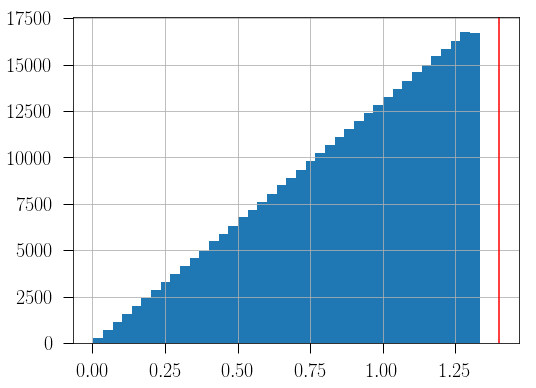

In [194]:
hist(rads, bins=40);
grid()
axvline(1.4, c='r')

In [195]:
histo, bins = np.histogram(rads, bins=45, weights=fluxs)

In [196]:
histnorm, bins2 = np.histogram(rads, bins=45)

In [197]:
np.diff(bins2)[0] * 60.

1.7739616653302799

In [198]:
bins = (bins[1:] + bins[:-1])/2.

In [199]:
bins2 = (bins2[1:] + bins2[:-1])/2.

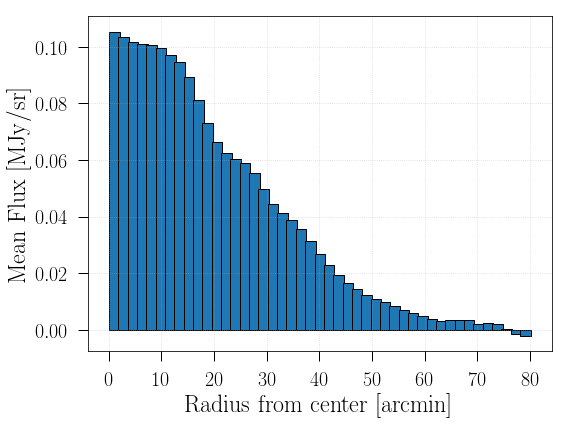

In [202]:
bar(x=bins * 60., height=histo/histnorm, width=2., edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ center\ [arcmin]}$')
ylabel('$\mathrm{Mean\ Flux\ [MJy/sr]}$')
xticks(np.linspace(0, 80, 9));
tight_layout()
#savefig('flux_radius_binned_destriped_deplaned_bankA.pdf', format='pdf')